In [1]:
!pip install numpy pandas scikit-fuzzy matplotlib requests

In [2]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('./data.csv')

In [4]:
min_age = data['Age'].min()
max_age = data['Age'].max()

print(f"Age Range: {min_age} - {max_age}")

heart_rate = ctrl.Antecedent(np.arange(40, 131, 1), 'heart_rate')
sleep_duration = ctrl.Antecedent(np.arange(0, 13, 1), 'sleep_duration')
work_load = ctrl.Antecedent(np.arange(0, 11, 1), 'work_load')
stress_level = ctrl.Consequent(np.arange(0, 11, 1), 'stress_level')

Age Range: 27 - 59


In [5]:
heart_rate['low'] = fuzz.trimf(heart_rate.universe, [40, 55, 70])
heart_rate['medium'] = fuzz.trimf(heart_rate.universe, [60, 85, 100])
heart_rate['high'] = fuzz.trimf(heart_rate.universe, [90, 110, 130])

sleep_duration['short'] = fuzz.trimf(sleep_duration.universe, [0, 0, 5])
sleep_duration['medium'] = fuzz.trimf(sleep_duration.universe, [4, 7, 9])
sleep_duration['long'] = fuzz.trimf(sleep_duration.universe, [8, 10, 12])

work_load['light'] = fuzz.trimf(work_load.universe, [0, 0, 3])
work_load['moderate'] = fuzz.trimf(work_load.universe, [2, 5, 8])
work_load['heavy'] = fuzz.trimf(work_load.universe, [7, 10, 10])

stress_level['low'] = fuzz.trimf(stress_level.universe, [0, 0, 4])
stress_level['medium'] = fuzz.trimf(stress_level.universe, [3, 5, 7])
stress_level['high'] = fuzz.trimf(stress_level.universe, [6, 10, 10])

C:\Users\Jimm\ai_env\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


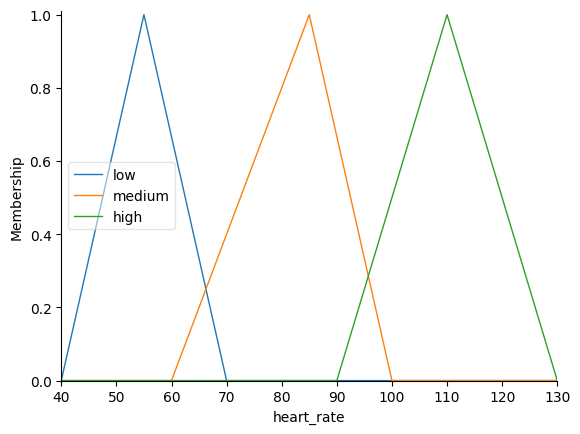

In [6]:
heart_rate.view()
plt.show()

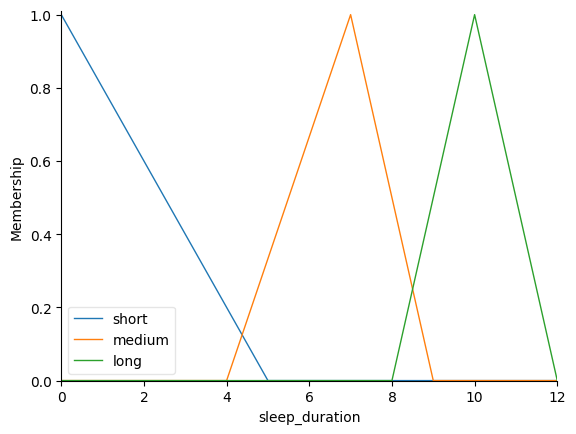

In [7]:
sleep_duration.view()
plt.show()

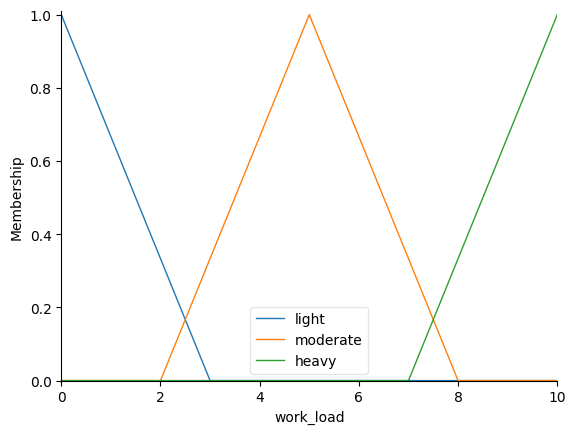

In [8]:
work_load.view()
plt.show()

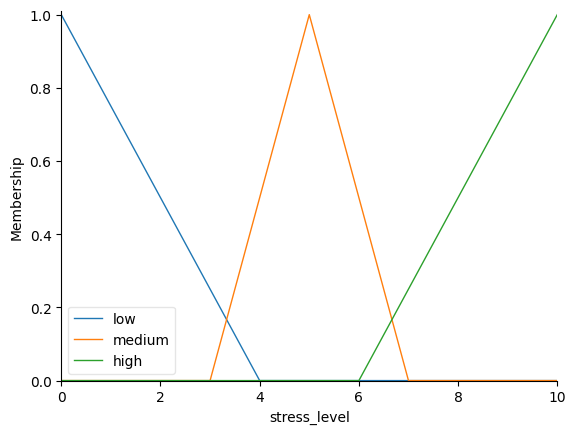

In [9]:
stress_level.view()
plt.show()

In [10]:
rule1 = ctrl.Rule(heart_rate['low'] & sleep_duration['long'] & work_load['light'], stress_level['low'])
rule2 = ctrl.Rule(heart_rate['medium'] & sleep_duration['medium'] & work_load['moderate'], stress_level['medium'])
rule3 = ctrl.Rule(heart_rate['high'] & sleep_duration['short'] & work_load['heavy'], stress_level['high'])
rule4 = ctrl.Rule(heart_rate['high'] & work_load['heavy'], stress_level['high'])
rule5 = ctrl.Rule(sleep_duration['short'] & work_load['heavy'], stress_level['high'])
rule6 = ctrl.Rule(sleep_duration['short'] & heart_rate['medium'], stress_level['medium'])
rule7 = ctrl.Rule(heart_rate['high'] & sleep_duration['short'], stress_level['high'])
rule8 = ctrl.Rule(heart_rate['medium'] & sleep_duration['medium'] & work_load['heavy'], stress_level['high'])
rule9 = ctrl.Rule(heart_rate['medium'] & sleep_duration['medium'] & work_load['light'], stress_level['low'])
rule_default = ctrl.Rule(antecedent=(heart_rate['medium'] | heart_rate['low']) &
                         (sleep_duration['medium'] | sleep_duration['long']) &
                         (work_load['light'] | work_load['moderate']),
                         consequent=stress_level['low'])

In [11]:
stress_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule_default])

In [12]:
def compute_stress_level(row):
    stress_sim = ctrl.ControlSystemSimulation(stress_ctrl)

    heart_rate_value = None
    sleep_duration_value = None
    work_load_value = None

    try:
        heart_rate_value = row['Heart Rate']
        sleep_duration_value = row['Sleep Duration']
        work_load_value = row['Work Load']

        heart_rate_value = np.clip(heart_rate_value, heart_rate.universe[0], heart_rate.universe[-1])
        sleep_duration_value = np.clip(sleep_duration_value, sleep_duration.universe[0], sleep_duration.universe[-1])
        work_load_value = np.clip(work_load_value, work_load.universe[0], work_load.universe[-1])

        stress_sim.input['heart_rate'] = heart_rate_value
        stress_sim.input['sleep_duration'] = sleep_duration_value
        stress_sim.input['work_load'] = work_load_value

        stress_sim.compute()

        return stress_sim.output['stress_level']

    except Exception as ex:
        print(f"Error computing for row {row.name}: {ex}")
        print(f"Inputs: heart_rate={heart_rate_value}, sleep_duration={sleep_duration_value}, work_load={work_load_value}")
        return np.nan

data['Stress Level'] = data.apply(compute_stress_level, axis=1)

In [13]:
percentage = 0.27
data[:int(len(data) * percentage)]

,Gender,Age,Occupation,Sleep Duration,Work Load,Heart Rate,Stress Level
0,Male,27,Software Engineer,6,6,77,3.222222
1,Male,28,Doctor,6,8,75,8.311111
2,Male,28,Doctor,6,8,75,8.311111
3,Male,28,Sales Representative,4,8,85,6.599020
4,Male,28,Sales Representative,4,8,85,6.599020
...,...,...,...,...,...,...,...
95,Female,36,Accountant,8,4,68,3.345959
96,Female,36,Accountant,8,4,68,3.345959
97,Female,36,Accountant,8,4,68,3.345959
98,Female,36,Teacher,8,4,68,3.345959


In [14]:
def classify_stress_level(score):
    if score >= 6.0:
        return 'High'
    elif score >= 3.0:
        return 'Medium'
    else:
        return 'Low'

data['Stress Level Category'] = data['Stress Level'].apply(classify_stress_level)

In [15]:
top_stress = data.sort_values(by='Stress Level', ascending=False)

top_stress.to_csv('top-stress.csv', index=False)

top_stress[['Heart Rate', 'Sleep Duration', 'Work Load', 'Stress Level', 'Stress Level Category']].head(10)


,Heart Rate,Sleep Duration,Work Load,Stress Level,Stress Level Category
304,75,6,8,8.311111,High
305,75,6,8,8.311111,High
296,75,6,8,8.311111,High
297,75,6,8,8.311111,High
303,75,6,8,8.311111,High
288,75,6,8,8.311111,High
289,75,6,8,8.311111,High
290,75,6,8,8.311111,High
291,75,6,8,8.311111,High
292,75,6,8,8.311111,High


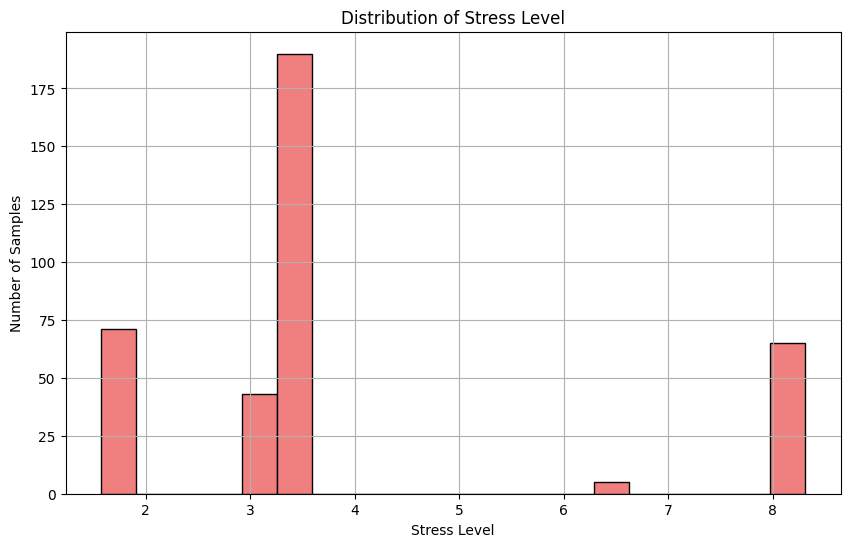

In [16]:
plt.figure(figsize=(10,6))
plt.hist(data['Stress Level'].dropna(), bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


Stress Level Category Counts:
Stress Level Category
Medium    200
Low       104
High       70
Name: count, dtype: int64


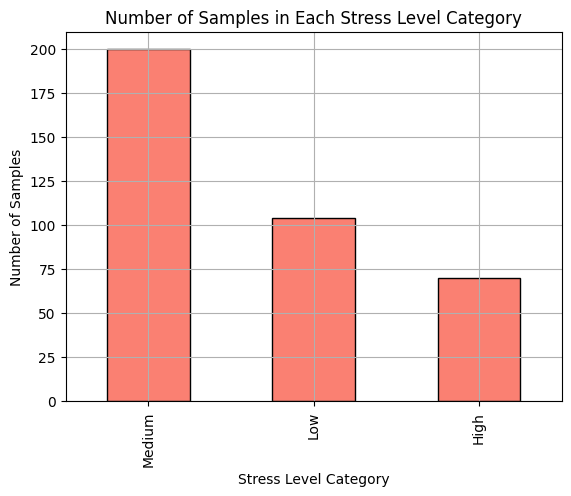

In [17]:
stress_counts = data['Stress Level Category'].value_counts()
print("Stress Level Category Counts:")
print(stress_counts)

stress_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Number of Samples in Each Stress Level Category')
plt.xlabel('Stress Level Category')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()